In [ ]:
# RUN TFLITE INFERENCE ON AN EXAMPLE DATASET

In [2]:
!pip3 install tflite-runtime

ERROR: Could not find a version that satisfies the requirement tflite-runtime (from versions: none)
ERROR: No matching distribution found for tflite-runtime


In [3]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.0 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 MB 33.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 43.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 32.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 42.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 42.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.4 MB/s eta 0:00:00
 

In [11]:
!pip install pandas numpy pyarrow fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 63.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.6/682.6 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 15.5 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np


ROWS_PER_FRAME = 543 #no of landmarks per frame

def load_relevant_data_subset(pq_file):
    data_columns = ['x','y','z']
    data = pd.read_parquet(pq_file, columns = data_columns)
    n_frames = int(len(data) /ROWS_PER_FRAME)
    print(len(data))
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    print(n_frames)
    return data.astype(np.float32)

In [13]:
#load in tflite model
import tensorflow as tf
# import tflite_runtime.interpreter as tflite

interpreter = tf.lite.Interpreter(model_path="./model.tflite")
interpreter.allocate_tensors()

found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")


In [14]:
train = pd.read_csv('../train_new_csv.csv')
train['sign_ord'] = train['sign'].astype('category').cat.codes
# print(train['sign_ord'])
#dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

pq_file = './output.parquet'
xyz_np = load_relevant_data_subset(pq_file)
prediction = prediction_fn(inputs = xyz_np)
sign = prediction['outputs'].argmax() 
print(prediction['outputs'])
# print(sign)



45612
84
[8.6997182e-04 1.6417833e-03 2.2350175e-03 1.2433246e-03 1.3633603e-03
 4.0837200e-04 3.0838989e-03 3.5600010e-03 3.4382388e-03 9.0500939e-04
 1.6896825e-03 1.4474310e-03 1.5987931e-03 1.4854714e-03 1.1388869e-03
 9.8042842e-04 1.1920837e-03 2.5659020e-03 9.0213475e-04 5.2439858e-04
 1.6423275e-03 1.9357132e-03 1.6917761e-03 1.0730104e-03 1.5690415e-03
 2.3330529e-03 4.4182250e-03 5.3228694e-04 1.0600077e-02 4.6246378e-03
 1.9510824e-03 1.7743710e-03 1.2418368e-03 6.0694595e-04 1.0960781e-03
 6.9890375e-04 1.6925589e-03 1.3900592e-03 1.9308496e-03 2.2787622e-03
 9.1683038e-04 1.6996477e-03 1.2464006e-03 3.0949195e-03 7.4418634e-04
 4.4248745e-04 4.3586190e-04 9.8694221e-04 1.3148328e-03 1.9633716e-03
 3.3566803e-03 2.0540082e-03 1.4130878e-03 2.2696380e-03 2.9748653e-03
 2.3231516e-03 6.3447235e-04 4.6769227e-03 6.6286237e-03 1.6162698e-03
 4.7746054e-03 8.9780905e-04 5.3355880e-03 1.7501202e-03 8.9905737e-04
 1.3106969e-03 6.2084943e-04 3.2419802e-03 7.1192381e-04 7.1015023e-

In [15]:
train['sign_ord'].max()

1

In [16]:
print(ORD2SIGN)

{1: 'thankyou', 0: 'hello'}


In [17]:
#this is a workaround for serialized signs in original dataset
if (sign==113):
    sign = 0
elif(sign==214):
    sign = 1

In [18]:
ORD2SIGN[sign]

'hello'

In [19]:
prediction

{'outputs': array([8.6997182e-04, 1.6417833e-03, 2.2350175e-03, 1.2433246e-03,
        1.3633603e-03, 4.0837200e-04, 3.0838989e-03, 3.5600010e-03,
        3.4382388e-03, 9.0500939e-04, 1.6896825e-03, 1.4474310e-03,
        1.5987931e-03, 1.4854714e-03, 1.1388869e-03, 9.8042842e-04,
        1.1920837e-03, 2.5659020e-03, 9.0213475e-04, 5.2439858e-04,
        1.6423275e-03, 1.9357132e-03, 1.6917761e-03, 1.0730104e-03,
        1.5690415e-03, 2.3330529e-03, 4.4182250e-03, 5.3228694e-04,
        1.0600077e-02, 4.6246378e-03, 1.9510824e-03, 1.7743710e-03,
        1.2418368e-03, 6.0694595e-04, 1.0960781e-03, 6.9890375e-04,
        1.6925589e-03, 1.3900592e-03, 1.9308496e-03, 2.2787622e-03,
        9.1683038e-04, 1.6996477e-03, 1.2464006e-03, 3.0949195e-03,
        7.4418634e-04, 4.4248745e-04, 4.3586190e-04, 9.8694221e-04,
        1.3148328e-03, 1.9633716e-03, 3.3566803e-03, 2.0540082e-03,
        1.4130878e-03, 2.2696380e-03, 2.9748653e-03, 2.3231516e-03,
        6.3447235e-04, 4.6769227e-03,

In [20]:
prediction['outputs'].shape

(250,)

<Axes: >

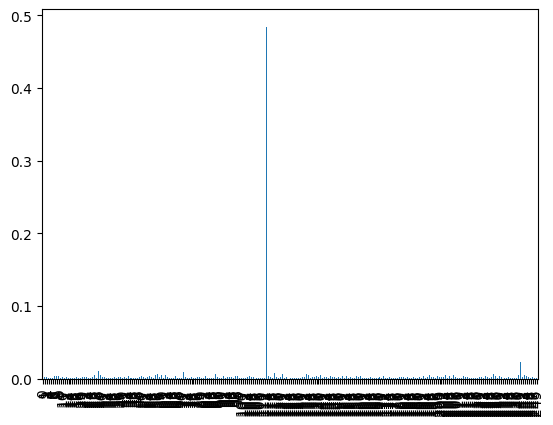

In [21]:
pd.Series(prediction['outputs']).plot(kind='bar')